In [1]:
import os
import pandas as pd
import numpy as np
import random
import datetime as dt
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AR
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split
from scipy.stats import norm
import math
import keras.backend as K
from keras.models import Sequential
from keras.layers import LSTM, Activation, Flatten, Dense, TimeDistributed

global tau
global T
global K_quantiles


Using TensorFlow backend.
/home/mason/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mason/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mason/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mason/.local/lib/python3.6/site-packages/tensorflow/python/fra

In [2]:
cwd = os.path.abspath('') + '/'
random.seed(1)

In [3]:
def GARCH(y, start, end, split_date):
    """ General Autoregressive Conditional Heteroskedasticity Model 
    p -> Lag length
    q -> Order of ARCH terms
    y -> Timeseries Dataframe
    """
    model = arch_model(y, vol='Garch', p=1, o=0, q=1, dist='StudentsT', rescale=False)
    results = model.fit(last_obs=split_date)
    print(results.summary())

    sims = results.forecast(horizon=8, start=split_date)
    
    sims.variance[split_date:].plot()
    plt.title("Variance Forecast from " + split_date.strftime("%m/%d/%Y") + " to " + end.strftime("%m/%d/%Y") + " (m/d/y)")
    plt.ylabel("Variance [%]")
    plt.show()


In [4]:
def Q(tau, mu, s, u, v, A=4):
    """ Heavy tailed quantile function proposed in the paper
    tau -> quantile
    mu  -> mean
    s   -> standard deviation
    u   -> function parameter ( u > 0)
    v   -> function parameter ( v > 0)
    A   -> realatively large positive constant (the paper chooses A=4)
    """
    Z_tau = norm(mu, s).ppf(tau)
    return mu + s*Z_tau * (math.exp(u * Z_tau) / A + 1) * (math.exp(-v * Z_tau) / A + 1)

In [5]:
def moment(x, mu, order):
    """ Returns the moment sepecified by the order
    x       -> value
    mu      -> mean
    order   -> what moment to return

    Example:
        moment(x, mu, 2) -> second moment
        moment(x, mu, 3) -> third moment
    """
    return (x-mu)**order

In [6]:
def calculate_feature_vector(r_t, L):
    """ Calculates the feature vector for the LSTM Machine
    r_t -> returns
    L -> Lookback length
    """
    mu = sum(r_t[-L-1:-1]) / L

    return np.array([   moment(r_t[-L], mu, 1),
                moment(r_t[-L], mu, 2),
                moment(r_t[-L], mu, 3),
                moment(r_t[-L], mu, 4)])

In [7]:
def partition_data(ts, L, p_train, p_test, p_val):
    X = []
    y = []

    for i in range(L+1, len(ts)):
        X.append(calculate_feature_vector(ts[i-L-1:i], L))
        y.append(ts[i])

    X = np.array(X)
    y = np.array(y)
    
    X_train = X[0:int(len(X)*p_train)]
    y_train = y[0:int(len(y)*p_train)]

    X_test = X[len(X_train):len(X_train) + int(len(X)*p_test)]
    y_test = y[len(X_train):len(X_train) + int(len(X)*p_test)]

    X_val = X[len(X_train) + len(X_test):len(X_train)+len(X_test)+int(len(X)*p_val)]
    y_val = y[len(X_train) + len(X_test):len(X_train)+len(X_test)+int(len(X)*p_val)]


    return X_train, y_train, X_test, y_test, X_val, y_val

In [8]:
def pinball_loss(y_true, y_pred):
    pin = 0
    return pin

Load the data from the 4th of January, 1950 to the 1st of June, 2018 and convert it into daily returns.

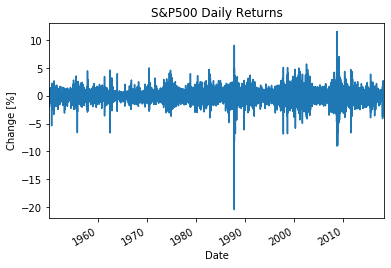

In [9]:
start = dt.datetime(1950, 1, 4)
end = dt.datetime(2018, 6, 1)

data = web.get_data_yahoo('^GSPC', start=start, end=end)

r_t = 100*data['Close'].pct_change().dropna()
plt.title("S&P500 Daily Returns")
plt.ylabel("Change [%]")
r_t.plot()
plt.show()


Run GARCH on the data and plot the results

Iteration:      1,   Func. Count:      7,   Neg. LLF: 17644.170571314113
Iteration:      2,   Func. Count:     20,   Neg. LLF: 17633.518859727705
Iteration:      3,   Func. Count:     28,   Neg. LLF: 17623.374491287337
Iteration:      4,   Func. Count:     38,   Neg. LLF: 17622.26381268903
Iteration:      5,   Func. Count:     46,   Neg. LLF: 17591.337203480463
Iteration:      6,   Func. Count:     54,   Neg. LLF: 17588.60756835413
Iteration:      7,   Func. Count:     62,   Neg. LLF: 17585.491727170767
Iteration:      8,   Func. Count:     71,   Neg. LLF: 17584.85115272994
Iteration:      9,   Func. Count:     79,   Neg. LLF: 17582.325831575166
Iteration:     10,   Func. Count:     87,   Neg. LLF: 17581.8377069433
Iteration:     11,   Func. Count:     95,   Neg. LLF: 17581.577925818747
Iteration:     12,   Func. Count:    103,   Neg. LLF: 17581.40302397536
Iteration:     13,   Func. Count:    110,   Neg. LLF: 17581.400180692537
Iteration:     14,   Func. Count:    117,   Neg. LLF: 175

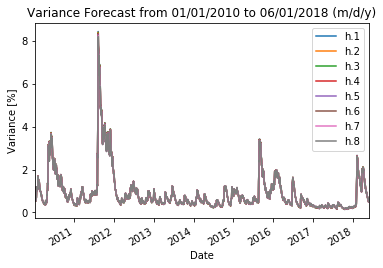

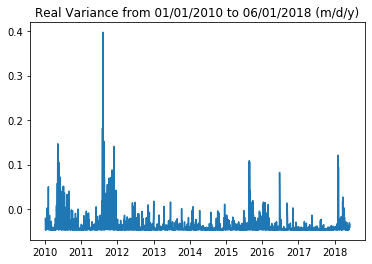

In [10]:

split_date = dt.datetime(2010, 1, 1)
GARCH(r_t, start, end, split_date)

# Plotting the acutal variances (assuming mean = 0)
actual_variance = r_t[split_date:]
actual_variance.values[:] = 100*(actual_variance.values[:]/100)**2 - actual_variance.mean()
plt.plot(actual_variance)
plt.title("Real Variance from " + split_date.strftime("%m/%d/%Y") + " to " + end.strftime("%m/%d/%Y") + " (m/d/y)")
plt.show()

In [11]:
L_set = [40,60,80,100]
H_set = [8, 16]
L = L_set[0] #! Take these out when you are doing tuning
H = H_set[0] #! Take these out when you are doing tuning
K_quantiles = 21

X_train, y_train, X_test, y_test, X_val, y_val = partition_data(r_t, L, 0.8, 0.1, 0.1)
quantiles = [i / (K_quantiles+1) for i in range(1, K_quantiles+1)]

In [12]:
X_train_rs = np.expand_dims(X_train, axis=1)

model = Sequential()
model.add(LSTM(H, input_shape=(1, 4)))

print(model.summary())

T = len(r_t)

for q in quantiles:
    tau = q
    model.compile(loss=pinball_loss, optimizer='adam')
    model.fit(X_train_rs, y_train)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 8)                 416       
Total params: 416
Trainable params: 416
Non-trainable params: 0
_________________________________________________________________
None


AttributeError: 'int' object has no attribute 'dtype'

In [0]:
print(len(X_train_rs))
print(X_train_rs.shape)
print(len(y_train))

In [0]:
x = np.array([[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12]])
y = x.reshape((x.shape[0]* x.shape[1]))
print(y)